# Import Library

In [13]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Sentiment Analysist Use Pretrained Model BERT Uncased + Fine tuned from cleaned datasets Before


## load dataset + delete duplicate

In [14]:
df = pd.read_excel('preprocessing_capegini.xlsx')

In [15]:
df

,text,sentiment
0,deserved candidate promoted promptly unbiased ...,1.0
1,got lot learning platform monthly learning pla...,1.0
2,based business unit get experience company pol...,1.0
3,client project good use latest tech work,1.0
4,worked ibm year tc year rd company year comple...,1.0
...,...,...
54022,amazon adopted giving responsibility workplace...,0.0
54023,terrible experience working amazon pay leaders...,0.0
54024,logistics supply management application operat...,0.0
54025,toxic culture depend team hierarchical questio...,0.0


In [16]:
# Remove rows with missing or invalid text data
df.dropna(subset=['text', 'sentiment'], inplace=True)


In [17]:
df

,text,sentiment
0,deserved candidate promoted promptly unbiased ...,1.0
1,got lot learning platform monthly learning pla...,1.0
2,based business unit get experience company pol...,1.0
3,client project good use latest tech work,1.0
4,worked ibm year tc year rd company year comple...,1.0
...,...,...
54021,le visibility next level promotion point time ...,0.0
54022,amazon adopted giving responsibility workplace...,0.0
54023,terrible experience working amazon pay leaders...,0.0
54024,logistics supply management application operat...,0.0


## preparation for sentiment analysis, consists:
- encode labels
- split data
- tokenize the text column on train and val

In [18]:
# Encode sentiment labels
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

In [19]:
df

,text,sentiment
0,deserved candidate promoted promptly unbiased ...,1
1,got lot learning platform monthly learning pla...,1
2,based business unit get experience company pol...,1
3,client project good use latest tech work,1
4,worked ibm year tc year rd company year comple...,1
...,...,...
54021,le visibility next level promotion point time ...,0
54022,amazon adopted giving responsibility workplace...,0
54023,terrible experience working amazon pay leaders...,0
54024,logistics supply management application operat...,0


In [20]:
# Split data into train and test sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'].tolist(), df['sentiment'].tolist(), test_size=0.2)


In [23]:
# Split data into train and test sets
train_texts1, val_texts1, train_labels1, val_labels1 = train_test_split(df['text'], df['sentiment'], test_size=0.2)


In [25]:
train_texts1.shape

(37132,)

In [26]:
val_texts1.shape

(9284,)

In [ ]:
# GPU check available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [ ]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)  # 2 classes: negative and positive
model.to(device) # using gpu cuda


In [ ]:
# Tokenize data
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=128)
val_encodings = tokenizer(val_texts, padding=True, truncation=True, max_length=128)


In [ ]:
# Create torch dataset
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

## fine tuned, results, and save.

The fine tuned consists:
- epoch: 3
-  bath size: 32

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    learning_rate=3e-5
)

In [ ]:
class CustomTrainer(Trainer):
    def _prepare_inputs(self, inputs):
        # Move inputs to the right device
        if torch.cuda.is_available():
            inputs = {k: v.to('cuda') for k, v in inputs.items()}
        return inputs

In [ ]:
# Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [ ]:
# Train model
trainer.train()

In [ ]:
# Evaluate model
results = trainer.evaluate()
print(results)

In [ ]:
# Save model pretrained model for hugging face
output_dir="D:\Project\Final Project Indonesia AI/02_11062024_bert_sentiment_model"
model.save_pretrained(output_dir, from_pt=True)
tokenizer.save_pretrained(output_dir)

## testing the fine tuned models with cleaned dataset

In [ ]:
# Load the fine-tuned model and tokenizer
model_path = '02_11062024_bert_sentiment_model'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

In [ ]:
input = pd.read_excel('lowercase_labels_datasets.xlsx')
input.head()
input.shape

In [ ]:
input.dropna(subset=['text', 'sentiment'], inplace=True)
input.shape

In [ ]:
# Split the data into train and test sets (use 20% for testing)
train_data, test_data = train_test_split(input, test_size=0.2, random_state=42)

In [ ]:
# Count the occurrences of each class in the 'output' column of the training data
class_counts = train_data['text'].value_counts()

# Print the counts of class 1 and 0
class_1_count = class_counts.get(1, 0)
class_0_count = class_counts.get(0, 0)

print("Number of instances of class '1' in the training data:", class_1_count)
print("Number of instances of class '0' in the training data:", class_0_count)

In [ ]:
# Count the occurrences of each class in the 'output' column of the training data
class_counts = test_data['text'].value_counts()

# Print the counts of class 1 and 0
class_1_count = class_counts.get(1, 0)
class_0_count = class_counts.get(0, 0)

print("Number of instances of class '1' in the training data:", class_1_count)
print("Number of instances of class '0' in the training data:", class_0_count)

In [ ]:
# Load the fine-tuned model and tokenizer
model_path = '02_11062024_bert_sentiment_model'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

In [ ]:
# Load the dataset
df = pd.read_excel('lowercase_text_only_datasets.xlsx')
df

In [ ]:
df.shape

In [ ]:
# Convert the text column into a list of strings
texts = df['text'].astype(str).tolist()

In [ ]:
# Function to tokenize text and obtain BERT embeddings
def tokenize_and_predict(texts):
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = outputs.logits
    return predictions

# Function to compute percentage (optional, if you want to see probabilities)
def compute_percentage(predictions):
    softmax_output = torch.softmax(predictions, dim=1)
    positive_percentage = softmax_output[:, 1].item() * 100
    negative_percentage = 100 - positive_percentage
    return positive_percentage, negative_percentage


In [ ]:
# Lists to store the results
sentiments = []
positive_percentages = []
negative_percentages = []

# Loop through the texts and make predictions
for text in texts:
    prediction = tokenize_and_predict(text)
    sentiment = "Positive" if prediction.argmax() == 1 else "Negative"
    positive_percentage, negative_percentage = compute_percentage(prediction)
    
    sentiments.append(sentiment)
    positive_percentages.append(positive_percentage)
    negative_percentages.append(negative_percentage)

In [ ]:
# Add the predictions and percentages as new columns in the DataFrame
df['sentiment'] = sentiments
df['positive_percentage'] = positive_percentages
df['negative_percentage'] = negative_percentages

In [ ]:
df

In [ ]:
# Save the DataFrame with the predictions to a new CSV file
df.to_excel('output_with_predictions.xlsx', index=False)

In [ ]:
print(df.head())

In [ ]:
# # Test sentiment with manual input. This is optionally, just ctrl + / for delete the comment! 


# # Function to tokenize text and obtain BERT embeddings
# def tokenize_and_predict(text):
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     predictions = outputs.logits
#     return predictions

# # Function to compute percentage
# def compute_percentage(predictions):
#     softmax_output = torch.softmax(predictions, dim=1)
#     positive_percentage = softmax_output[:, 1].item() * 100
#     negative_percentage = 100 - positive_percentage
#     return positive_percentage, negative_percentage

# # User input
# user_text = (
#              '''
#             its a nice experiance, i gain so many knowledge related to work.
# overall nice experiance and good work environment
#             '''
#              )

# # Tokenize user input and get predictions
# user_predictions = tokenize_and_predict(user_text)
# positive_percentage, negative_percentage = compute_percentage(user_predictions)

# # Determine sentiment
# sentiment = "Positive" if user_predictions.argmax() == 1 else "Negative"

# print("Sentiment:", sentiment)
# print("Positive sentiment percentage:", positive_percentage)
# print("Negative sentiment percentage:", negative_percentage)

## Evaluation and Visualization The Model Perform

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification

d:\Project\Final Project Indonesia AI\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# GPU check available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [11]:
# Load the fine-tuned model and tokenizer
model_path = '02_11062024_bert_sentiment_model'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [4]:
input = pd.read_excel('lowercase_labels_datasets.xlsx')
input.head()
input.shape

(54026, 2)

In [5]:
input.dropna(subset=['text', 'sentiment'], inplace=True)
input.shape

(46867, 2)

In [6]:
# Split the data into train and test sets (use 20% for testing)
train_data, test_data = train_test_split(input, test_size=0.2, random_state=42)

In [7]:
print(train_data.shape)
print(test_data.shape)

(37493, 2)
(9374, 2)


In [ ]:
train_data.columns

In [8]:
# Convert DataFrame columns to lists of strings
train_texts = train_data['text'].astype(str).tolist()
train_labels = train_data['sentiment'].tolist()
test_texts = test_data['text'].astype(str).tolist()
test_labels = test_data['sentiment'].tolist()

In [9]:
# Function to tokenize text and obtain BERT embeddings

def tokenize_predict(texts, batch_size=8):
    predictions = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
        inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to the same device as the model
        with torch.no_grad():
            outputs = model(**inputs)
        predictions.append(outputs.logits)
    predictions = torch.cat(predictions, dim=0)
    return predictions

# Function to convert logits to predicted labels
def get_predicted_labels(predictions):
    return predictions.argmax(dim=1).tolist()

In [12]:
# Make predictions on the test set
test_predictions = tokenize_predict(test_texts)
predicted_labels = get_predicted_labels(test_predictions)

d:\Project\Final Project Indonesia AI\.venv\lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [13]:
# Evaluate the model using various metrics
print("Classification Report:")
report = classification_report(test_labels, predicted_labels, target_names=['Negative', 'Positive'])
print(report)


Classification Report:
              precision    recall  f1-score   support

    Negative       0.72      0.67      0.70      4550
    Positive       0.71      0.75      0.73      4824

    accuracy                           0.71      9374
   macro avg       0.71      0.71      0.71      9374
weighted avg       0.71      0.71      0.71      9374



In [14]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.7141


In [15]:
# Calculate precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='binary')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.7097
Recall: 0.7521
F1 Score: 0.7303


In [21]:
# Calculate ROC-AUC score
roc_auc = roc_auc_score(test_labels, predicted_labels)
print(roc_auc)

0.7129595611685163


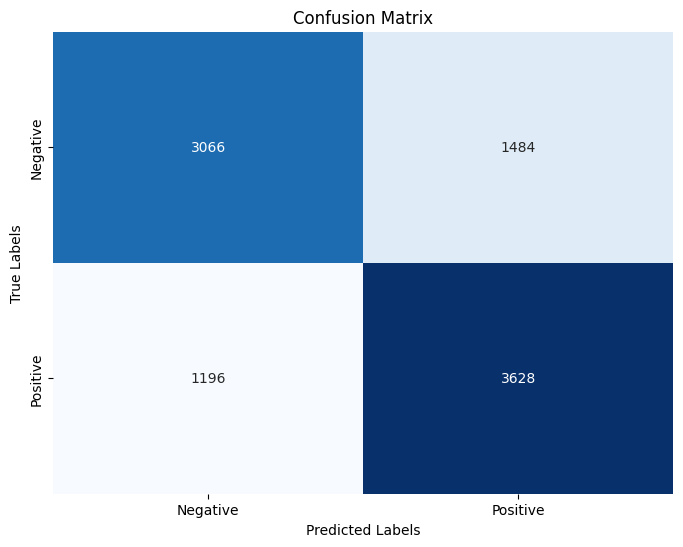

In [17]:
# Confusion Matrix
def visualize_confusion_matrix(true_labels, predicted_labels, save_path=None):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    if save_path:
        plt.savefig(save_path)
    plt.show()

visualize_confusion_matrix(test_labels, predicted_labels, save_path='confusion_matrix.png')


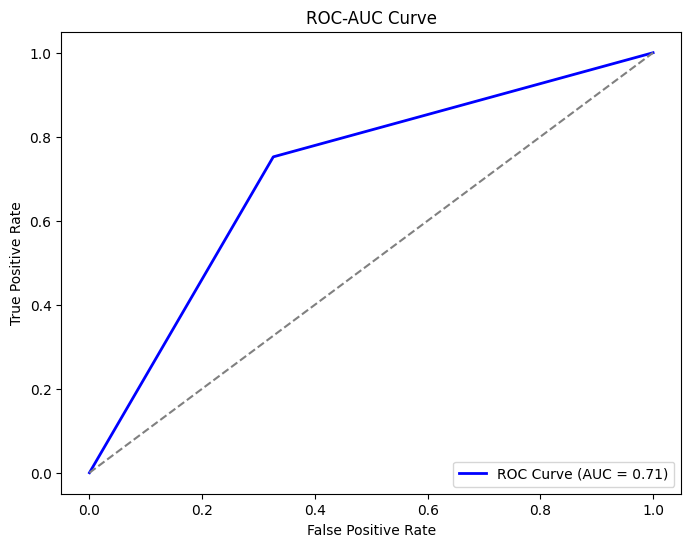

In [18]:
# ROC-AUC Curve
def visualize_roc_auc(true_labels, predicted_labels, save_path=None):
    roc_auc = roc_auc_score(true_labels, predicted_labels)
    fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    if save_path:
        plt.savefig(save_path)
    plt.show()

visualize_roc_auc(test_labels, predicted_labels, save_path='roc_auc_curve.png')

In [25]:
evaluation_metrics = {
    'Model': ['Bert'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'ROC-AUC': [roc_auc]
}

evaluation_df = pd.DataFrame(evaluation_metrics)
print(evaluation_df)

  Model  Accuracy  Precision    Recall  F1 Score  ROC-AUC
0  Bert  0.714103   0.709703  0.752073  0.730274  0.71296


In [27]:
# Save evaluation metrics to a CSV file
evaluation_df.to_excel('evaluation_metrics.xlsx', index=False)
print('Evaluation metrics saved to evaluation_metrics.csv')

Evaluation metrics saved to evaluation_metrics.csv
